In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [281]:
file = "../data/raw/houses_moreinfo.csv"
df = pd.read_csv(file)

In [282]:
df = df.drop('has_balcony', axis=1) # Remove 'has_balcony' column
df = df.drop('id', axis=1)
df = df.drop('sale_type', axis=1)

df = df[df['heating'].notna()] # Remove all properties where 'price' is NaN
df = df[df['price'].notna()] 
df = df[df['epc'].notna()]
df = df[df['state_construction'].notna()]
df = df[df['bathrooms'].notna()]
df = df[df['life_annuity'] != 1]
df = df.drop('life_annuity', axis=1)
df = df[df['construction_year'].notna()] # optional (subset)

In [283]:
print('Number of properties left after cleaning:', df.shape[0])

Number of properties left after cleaning: 11695


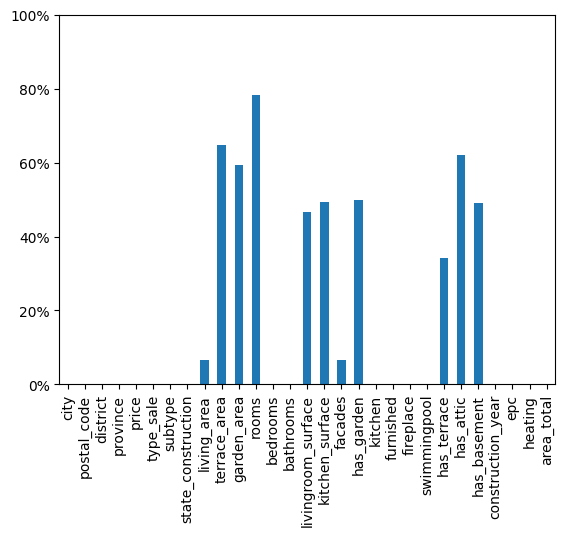

In [284]:
number_of_rows = df.shape[0]
number_of_nan_rows = df.isna().sum()
percentage_of_nan = (number_of_nan_rows / number_of_rows) * 100

percentage_of_nan.plot(kind='bar')
plt.ylim(0, 100)
ticks = np.arange(0, 101, step=20)

plt.yticks(ticks, [f"{tick}%" for tick in ticks])

plt.show()

In [285]:
df


,city,postal_code,district,province,price,type_sale,subtype,state_construction,living_area,terrace_area,...,furnished,fireplace,swimmingpool,has_terrace,has_attic,has_basement,construction_year,epc,heating,area_total
6,Forest,1190,Brussels,Brussels,599000.0,HOUSE,HOUSE,GOOD,260.0,NaN,...,0,0,0,1.0,1.0,1.0,1760.0,G,GAS,0.0
11,Bredene,8450,Oostend,West Flanders,245000.0,HOUSE,HOUSE,AS_NEW,76.0,NaN,...,0,0,0,NaN,NaN,NaN,2023.0,B,GAS,150.0
38,Manage,7170,Charleroi,Hainaut,209000.0,HOUSE,HOUSE,AS_NEW,180.0,NaN,...,0,1,0,1.0,1.0,1.0,1975.0,C,GAS,0.0
40,DENDERMONDE,9200,Dendermonde,East Flanders,599000.0,HOUSE,HOUSE,GOOD,335.0,NaN,...,0,0,0,NaN,NaN,NaN,1930.0,C,GAS,181.0
52,Nivelles,1400,Nivelles,Walloon Brabant,275000.0,HOUSE,APARTMENT_BLOCK,AS_NEW,130.0,NaN,...,0,1,0,NaN,NaN,1.0,1975.0,G,GAS,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45057,Hoboken,2660,Antwerp,Antwerp,499000.0,HOUSE,HOUSE,JUST_RENOVATED,293.0,NaN,...,0,1,0,NaN,NaN,NaN,1937.0,E,GAS,435.0
45059,Hoboken,2660,Antwerp,Antwerp,535000.0,HOUSE,HOUSE,TO_BE_DONE_UP,201.0,30.0,...,0,1,0,1.0,NaN,NaN,1986.0,D,GAS,630.0
45060,Hoboken,2660,Antwerp,Antwerp,569000.0,HOUSE,HOUSE,GOOD,155.0,NaN,...,0,1,0,NaN,NaN,NaN,1988.0,B,GAS,623.0
45061,Hemiksem,2620,Antwerp,Antwerp,425000.0,HOUSE,MIXED_USE_BUILDING,TO_RENOVATE,164.0,NaN,...,0,1,0,NaN,NaN,1.0,1954.0,D,GAS,422.0


In [286]:
df.columns

Index(['city', 'postal_code', 'district', 'province', 'price', 'type_sale',
       'subtype', 'state_construction', 'living_area', 'terrace_area',
       'garden_area', 'rooms', 'bedrooms', 'bathrooms', 'livingroom_surface',
       'kitchen_surface', 'facades', 'has_garden', 'kitchen', 'furnished',
       'fireplace', 'swimmingpool', 'has_terrace', 'has_attic', 'has_basement',
       'construction_year', 'epc', 'heating', 'area_total'],
      dtype='object')